# Real-Time Credit Card Fraud Detection

## Loading the File and Performing Basic Data Type Conversions

In [1]:
# import modules from pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
import pandas as pd

# uncomment the following line if running pyspark from the notebook itself
# spark = SparkSession.builder.enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
sqlContext = SQLContext(spark)

# Read The data
cc_raw = (spark.read
  .option("header", "true")
  .csv("fraudTrain.csv"))

/usr/local/Cellar/apache-spark/3.5.0/libexec/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
# Register spark SQL tables

cc_raw.createOrReplaceTempView("cc_raw")

In [3]:
cc_raw.describe().toPandas()

,summary,_c0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,...,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
1,mean,648337.0,None,4.1719204207972077E17,None,None,70.35103545607046,None,None,None,...,38.53762161490217,-90.22633537864573,88824.44056297839,None,None,Infinity,1.3492436367261226E9,38.537338044699666,-90.22646479897256,0.005788651743883394
2,stddev,374317.9744882685,None,1.3088064470002432E18,None,None,160.3160385715277,None,None,None,...,5.075808438803937,13.759076946486305,301956.3606887509,None,None,NaN,1.2841278423361162E7,5.10978836967917,13.771090564792418,0.07586268973125161
3,min,0,2019-01-01 00:00:18,180011453250192,fraud_Abbott-Rogahn,entertainment,1.0,Aaron,Abbott,F,...,20.0271,-100.13799999999999,100,Academic librarian,1924-10-30,00000ecad06b03d3a8d34b4e30b5ce3b,1325376018,19.027785,-100.000064,0
4,max,999999,2020-06-21 12:13:37,676372984911,fraud_Zulauf LLC,travel,9999.39,Zachary,Zuniga,M,...,66.6933,-99.959,9993,Writer,2005-01-29,ffffef9d89e7d02d86efb1d2ba4de008,1371816817,67.510267,-99.999914,1


In [4]:
spark.sql("DROP TABLE IF EXISTS cc")

DataFrame[]

In [5]:
spark.sql(""" CREATE TABLE IF NOT EXISTS cc AS 
                SELECT timestamp(trans_date_trans_time) as trans_date_trans_time,
                       cc_num, 
                       merchant, 
                       category,
                       double(amt) as amt,
                       first,
                       last,
                       gender,
                       street,
                       city,
                       state,
                       zip,
                       double(lat) as lat,
                       double(long) as long,
                       double(city_pop) as city_pop,
                       job,
                       date(dob) as dob,
                       trans_num,
                       unix_time,
                       double(merch_lat) as merch_lat,
                       double(merch_long) as merch_long,
                       int(is_fraud) as is_fraud
                  FROM cc_raw
          """)

DataFrame[]

In [6]:
sqlContext.cacheTable("cc")

cc = spark.sql("SELECT * FROM cc")

## Exploratory Data Analysis

### A Look at the Data and its Basic Statistics

In [7]:
cc.columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud']

In [8]:
import pandas as pd

pd.DataFrame(cc.take(50), columns=cc.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-03-03 23:03:28,4710792708725663,fraud_Reichel LLC,personal_care,67.15,Justin,Bell,M,954 Green Wall,Churubusco,...,41.2290,-85.3244,7692.0,"Research officer, trade union",1986-12-13,2d01843a34527106763b3abe5a7254a7,1330815808,40.745523,-85.244040,0
1,2019-03-03 23:03:39,4208110975550360171,"fraud_Hettinger, McCullough and Fay",home,75.08,David,Bonilla,M,82073 Jessica Camp,West Green,...,31.6143,-82.7243,782.0,Audiological scientist,1982-01-16,67cf9f5a36be7520bdbee4528d18d2cf,1330815819,31.412858,-83.612354,0
2,2019-03-03 23:04:31,180048185037117,fraud_Feil-Morar,health_fitness,95.92,Mary,Wall,F,2481 Mills Lock,Plainfield,...,40.6152,-74.4150,71485.0,Leisure centre manager,1974-07-19,30a1485b54edcd37b0d6b846ae35f795,1330815871,41.145955,-74.444328,0
3,2019-03-03 23:04:41,373905417449658,fraud_Hudson-Grady,shopping_pos,282.90,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,Meridian,...,31.9290,-97.6443,2526.0,Phytotherapist,1970-11-12,c20d3c601381c520389277e90b4be2e0,1330815881,30.952434,-97.090499,0
4,2019-03-03 23:05:22,4956828990005111019,fraud_Heathcote LLC,shopping_net,3.68,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,40.6747,-74.2239,124967.0,Operational researcher,1980-12-21,bd86c93f72521b3dc0e89f9ce45a0a1e,1330815922,41.136261,-73.511146,0
5,2019-03-03 23:05:40,377993105397617,fraud_Pouros-Conroy,shopping_pos,2.47,Nathan,Martinez,M,586 Thomas Cliffs,Oconto Falls,...,44.8755,-88.1555,5548.0,Mining engineer,1975-09-11,315717dee35e0dfef80fbb68e9548873,1330815940,44.403661,-88.231581,0
6,2019-03-03 23:06:05,30328384440870,"fraud_Yost, Schamberger and Windler",kids_pets,20.35,Helen,Campbell,F,182 Sergio Summit Apt. 129,Browning,...,40.0290,-93.1607,602.0,Cytogeneticist,1954-07-14,64c7d11b46870d715b14c6ff16ce7bfc,1330815965,40.794946,-92.896900,0
7,2019-03-03 23:06:06,2254917871818484,fraud_Predovic Inc,shopping_net,7.70,Margaret,Gibson,F,382 Williams Stream Suite 197,Scotland,...,38.0828,-76.3477,313.0,Insurance underwriter,1976-03-26,0be691b0f03e2311b25f663670db0a2b,1330815966,37.907831,-76.296636,0
8,2019-03-03 23:06:25,30153452207526,"fraud_Prosacco, Kreiger and Kovacek",home,75.74,Robin,Smith,F,0537 Margaret Common Suite 526,Coleman,...,31.8287,-99.4270,5908.0,Radio producer,1962-04-05,81b1dd9d92d602e494514a207af6a872,1330815985,32.648138,-98.980787,0
9,2019-03-03 23:06:32,4710792708725663,fraud_Breitenberg-Hermiston,kids_pets,19.79,Justin,Bell,M,954 Green Wall,Churubusco,...,41.2290,-85.3244,7692.0,"Research officer, trade union",1986-12-13,87a72b9238b7bea1cb9d24b044feb23d,1330815992,40.431164,-84.568516,0


In [9]:
# making sure there are no missing values
cc.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in cc.columns)).toPandas()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualizing the Data Distribution

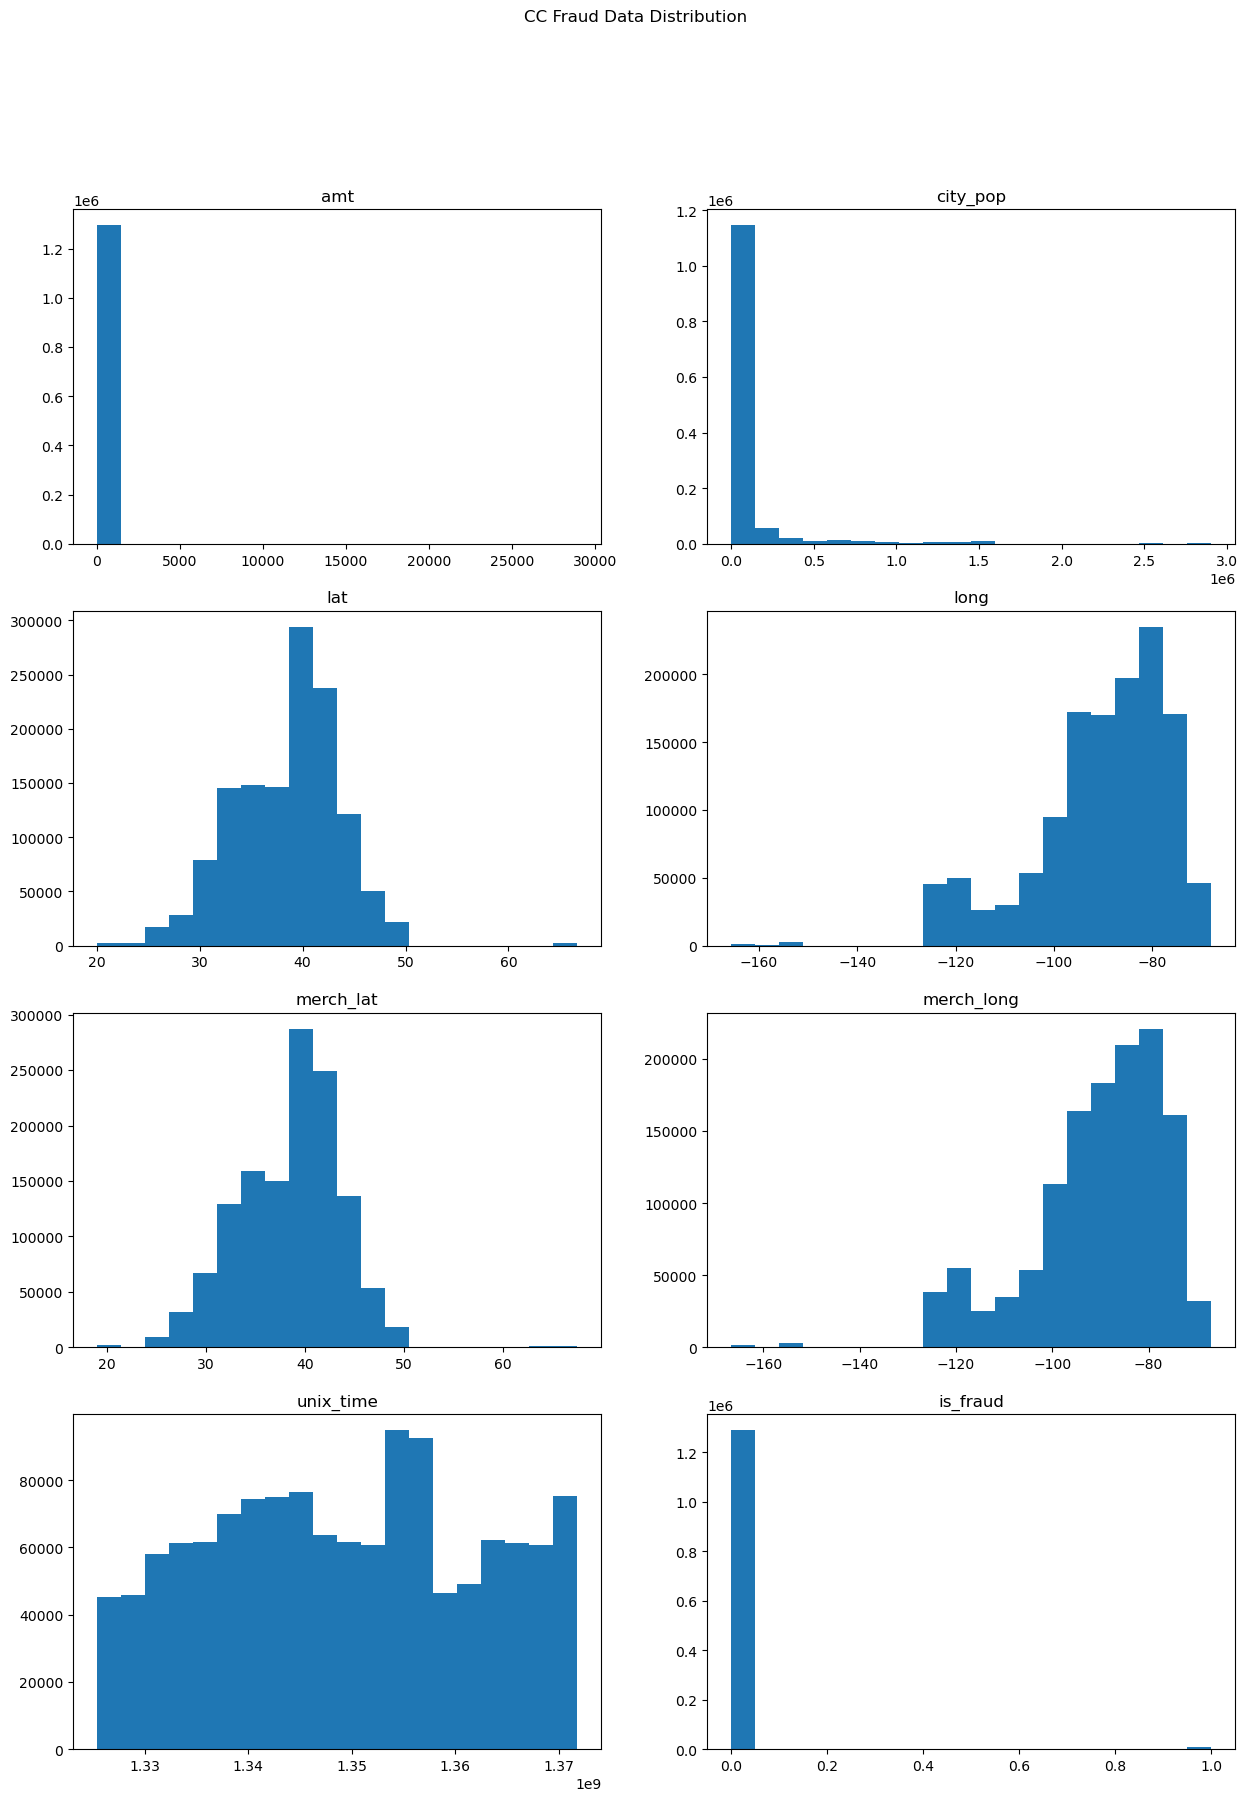

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4 , 2, figsize=(15, 20))
fig.suptitle('CC Fraud Data Distribution')

for idx, column in enumerate(['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'unix_time', 'is_fraud']):
    # Show histogram of the column
    bins, counts = cc.select(column).rdd.flatMap(lambda x: x).map(float).histogram(20)
    axs[idx//2][idx%2].set_title(column)
    axs[idx//2][idx%2].hist(bins[:-1], bins=bins, weights=counts)
    
plt.show()

In [11]:
cc.select("category").groupby("category").count().toPandas()

,category,count
0,travel,40507
1,misc_net,63287
2,grocery_pos,123638
3,kids_pets,113035
4,shopping_net,97543
5,grocery_net,45452
6,food_dining,91461
7,gas_transport,131659
8,personal_care,90758
9,health_fitness,85879


In [12]:
cc.select("gender").groupby("gender").count().toPandas()

,gender,count
0,F,709863
1,M,586812


In [13]:
# diamonds.select("clarity").groupby("clarity").count().toPandas()

NameError: name 'diamonds' is not defined

### Findings Summary and Strategy for Data Preparation

The data appears to be clean with no missing values. However, given that carat and price are heavily right skewed, I will apply a logarithmic transformation to them. The categorical features are of String type. As such, I will first need to encode them to a numeric indices and then one-hot encode the indices.

## Data Preparation

### Data Transformation

In [14]:
from pyspark.ml.feature import StringIndexer

# convert string categorical features to numeric indices
inputs = ['merchant', 'category', 'gender', 'city', 'state', 'job']
outputs = ['merchant_idx', 'category_idx', 'gender_idx', 'city_idx', 'state_idx', 'job_idx']
stringIndexer = StringIndexer(inputCols=inputs, outputCols=outputs)
model = stringIndexer.fit(cc)
cc_idx = model.transform(cc)

In [15]:
pd.DataFrame(cc_idx.take(50), columns=cc_idx.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,unix_time,merch_lat,merch_long,is_fraud,merchant_idx,category_idx,gender_idx,city_idx,state_idx,job_idx
0,2019-03-03 23:03:28,4710792708725663,fraud_Reichel LLC,personal_care,67.15,Justin,Bell,M,954 Green Wall,Churubusco,...,1330815808,40.745523,-85.244040,0,442.0,8.0,1.0,607.0,17.0,136.0
1,2019-03-03 23:03:39,4208110975550360171,"fraud_Hettinger, McCullough and Fay",home,75.08,David,Bonilla,M,82073 Jessica Camp,West Green,...,1330815819,31.412858,-83.612354,0,145.0,2.0,1.0,524.0,21.0,28.0
2,2019-03-03 23:04:31,180048185037117,fraud_Feil-Morar,health_fitness,95.92,Mary,Wall,F,2481 Mills Lock,Plainfield,...,1330815871,41.145955,-74.444328,0,455.0,9.0,0.0,47.0,23.0,160.0
3,2019-03-03 23:04:41,373905417449658,fraud_Hudson-Grady,shopping_pos,282.90,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,Meridian,...,1330815881,30.952434,-97.090499,0,209.0,3.0,0.0,4.0,0.0,150.0
4,2019-03-03 23:05:22,4956828990005111019,fraud_Heathcote LLC,shopping_net,3.68,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,1330815922,41.136261,-73.511146,0,270.0,5.0,1.0,105.0,23.0,205.0
5,2019-03-03 23:05:40,377993105397617,fraud_Pouros-Conroy,shopping_pos,2.47,Nathan,Martinez,M,586 Thomas Cliffs,Oconto Falls,...,1330815940,44.403661,-88.231581,0,168.0,3.0,1.0,189.0,13.0,26.0
6,2019-03-03 23:06:05,30328384440870,"fraud_Yost, Schamberger and Windler",kids_pets,20.35,Helen,Campbell,F,182 Sergio Summit Apt. 129,Browning,...,1330815965,40.794946,-92.896900,0,166.0,4.0,0.0,357.0,9.0,63.0
7,2019-03-03 23:06:06,2254917871818484,fraud_Predovic Inc,shopping_net,7.70,Margaret,Gibson,F,382 Williams Stream Suite 197,Scotland,...,1330815966,37.907831,-76.296636,0,257.0,5.0,0.0,97.0,20.0,53.0
8,2019-03-03 23:06:25,30153452207526,"fraud_Prosacco, Kreiger and Kovacek",home,75.74,Robin,Smith,F,0537 Margaret Common Suite 526,Coleman,...,1330815985,32.648138,-98.980787,0,125.0,2.0,0.0,310.0,0.0,74.0
9,2019-03-03 23:06:32,4710792708725663,fraud_Breitenberg-Hermiston,kids_pets,19.79,Justin,Bell,M,954 Green Wall,Churubusco,...,1330815992,40.431164,-84.568516,0,249.0,4.0,1.0,607.0,17.0,136.0


In [16]:
cc.count()

1296675

In [17]:
from pyspark.ml.feature import OneHotEncoder

# one-hot encode indexed categorical features
inputs_1hot = ['merchant_idx', 'category_idx', 'city_idx', 'state_idx', 'job_idx']
outputs_1hot = ['merchant_1hot', 'category_1hot', 'city_1hot', 'state_1hot', 'job_1hot']

oneHotEncoder = OneHotEncoder(inputCols=inputs_1hot, outputCols=outputs_1hot)
model_1hot = oneHotEncoder.fit(cc_idx)
cc_1hot = model_1hot.transform(cc_idx)

In [18]:
pd.DataFrame(cc_1hot.take(50), columns=cc_1hot.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,category_idx,gender_idx,city_idx,state_idx,job_idx,merchant_1hot,category_1hot,city_1hot,state_1hot,job_1hot
0,2019-03-03 23:03:28,4710792708725663,fraud_Reichel LLC,personal_care,67.15,Justin,Bell,M,954 Green Wall,Churubusco,...,8.0,1.0,607.0,17.0,136.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2019-03-03 23:03:39,4208110975550360171,"fraud_Hettinger, McCullough and Fay",home,75.08,David,Bonilla,M,82073 Jessica Camp,West Green,...,2.0,1.0,524.0,21.0,28.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2019-03-03 23:04:31,180048185037117,fraud_Feil-Morar,health_fitness,95.92,Mary,Wall,F,2481 Mills Lock,Plainfield,...,9.0,0.0,47.0,23.0,160.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2019-03-03 23:04:41,373905417449658,fraud_Hudson-Grady,shopping_pos,282.90,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,Meridian,...,3.0,0.0,4.0,0.0,150.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2019-03-03 23:05:22,4956828990005111019,fraud_Heathcote LLC,shopping_net,3.68,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,5.0,1.0,105.0,23.0,205.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,2019-03-03 23:05:40,377993105397617,fraud_Pouros-Conroy,shopping_pos,2.47,Nathan,Martinez,M,586 Thomas Cliffs,Oconto Falls,...,3.0,1.0,189.0,13.0,26.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,2019-03-03 23:06:05,30328384440870,"fraud_Yost, Schamberger and Windler",kids_pets,20.35,Helen,Campbell,F,182 Sergio Summit Apt. 129,Browning,...,4.0,0.0,357.0,9.0,63.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2019-03-03 23:06:06,2254917871818484,fraud_Predovic Inc,shopping_net,7.70,Margaret,Gibson,F,382 Williams Stream Suite 197,Scotland,...,5.0,0.0,97.0,20.0,53.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,2019-03-03 23:06:25,30153452207526,"fraud_Prosacco, Kreiger and Kovacek",home,75.74,Robin,Smith,F,0537 Margaret Common Suite 526,Coleman,...,2.0,0.0,310.0,0.0,74.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,2019-03-03 23:06:32,4710792708725663,fraud_Bre

In [19]:
# apply logarithmic transformation to carat and price features
cc_prepped = cc_1hot.withColumn('amt_log', log(col("amt"))) \
                                .withColumn('city_pop_log', log(col("city_pop")))

In [20]:
pd.DataFrame(cc_prepped.take(50), columns=cc_prepped.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_idx,state_idx,job_idx,merchant_1hot,category_1hot,city_1hot,state_1hot,job_1hot,amt_log,city_pop_log
0,2019-03-03 23:03:28,4710792708725663,fraud_Reichel LLC,personal_care,67.15,Justin,Bell,M,954 Green Wall,Churubusco,...,607.0,17.0,136.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.206929,8.947936
1,2019-03-03 23:03:39,4208110975550360171,"fraud_Hettinger, McCullough and Fay",home,75.08,David,Bonilla,M,82073 Jessica Camp,West Green,...,524.0,21.0,28.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.318554,6.661855
2,2019-03-03 23:04:31,180048185037117,fraud_Feil-Morar,health_fitness,95.92,Mary,Wall,F,2481 Mills Lock,Plainfield,...,47.0,23.0,160.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.563515,11.177243
3,2019-03-03 23:04:41,373905417449658,fraud_Hudson-Grady,shopping_pos,282.90,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,Meridian,...,4.0,0.0,150.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.645093,7.834392
4,2019-03-03 23:05:22,4956828990005111019,fraud_Heathcote LLC,shopping_net,3.68,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,...,105.0,23.0,205.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.302913,11.735805
5,2019-03-03 23:05:40,377993105397617,fraud_Pouros-Conroy,shopping_pos,2.47,Nathan,Martinez,M,586 Thomas Cliffs,Oconto Falls,...,189.0,13.0,26.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.904218,8.621193
6,2019-03-03 23:06:05,30328384440870,"fraud_Yost, Schamberger and Windler",kids_pets,20.35,Helen,Campbell,F,182 Sergio Summit Apt. 129,Browning,...,357.0,9.0,63.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.013081,6.400257
7,2019-03-03 23:06:06,2254917871818484,fraud_Predovic Inc,shopping_net,7.70,Margaret,Gibson,F,382 Williams Stream Suite 197,Scotland,...,97.0,20.0,53.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.041220,5.746203
8,2019-03-03 23:06:25,30153452207526,"fraud_Prosacco, Kreiger and Kovacek",home,75.74,Robin,Smith,F,0537 Margaret Common Suite 526,Coleman,...,310.0,0.0,74.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.

### Review of Revised Distribution for Amt and City_Pop

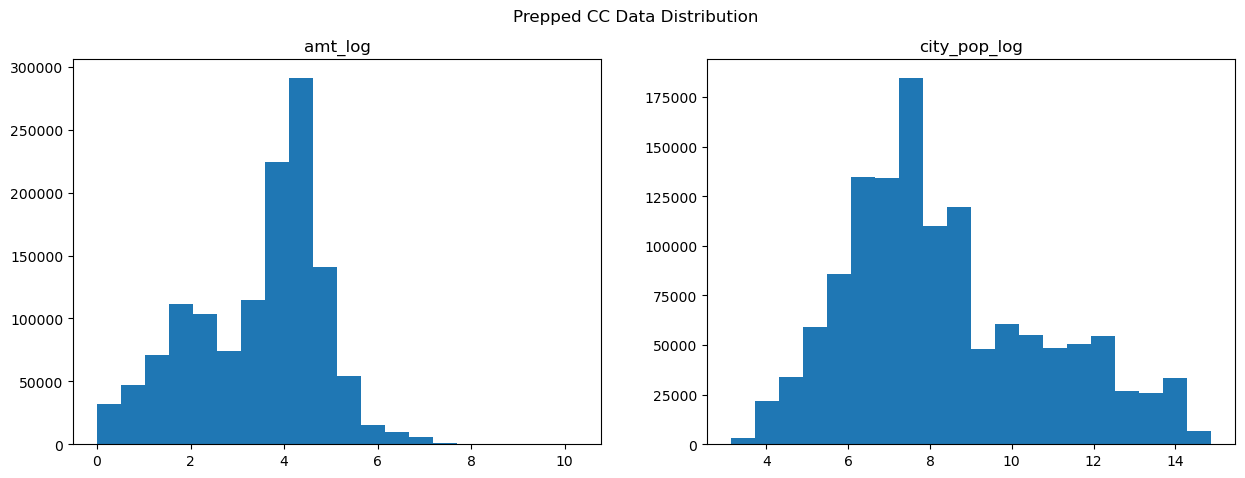

In [21]:
# plot revised data distribution
fig, axs = plt.subplots(1 , 2, figsize=(15, 5))
fig.suptitle('Prepped CC Data Distribution')

for idx, column in enumerate(['amt_log', 'city_pop_log']):
    # Show histogram of the column
    bins, counts = cc_prepped.select(column).rdd.flatMap(lambda x: x).map(float).histogram(20)
    axs[idx%2].set_title(column)
    axs[idx%2].hist(bins[:-1], bins=bins, weights=counts)
    
plt.show()

### Feature Extraction and Training/Test DataSet Creation

In [22]:
cc_prepped.columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'merchant_idx',
 'category_idx',
 'gender_idx',
 'city_idx',
 'state_idx',
 'job_idx',
 'merchant_1hot',
 'category_1hot',
 'city_1hot',
 'state_1hot',
 'job_1hot',
 'amt_log',
 'city_pop_log']

In [23]:
from pyspark.ml.feature import VectorAssembler

# assemble the prepped features into one single vector.
featureCols = ['amt_log', 'city_pop_log', 'job_1hot', 'state_1hot', 'category_1hot', 'gender_idx']
assembler = (VectorAssembler()
  .setInputCols(featureCols)
  .setOutputCol("features"))

cc_final = assembler.transform(cc_prepped)

In [24]:
# diamonds_final.toPandas()

In [25]:
# setup training and test datasets

training, test = cc_final.randomSplit([0.7, 0.3])

#  Going to cache the data to make sure things stay snappy!
# training.cache()
# test.cache()

print(training.count()) # Why execute count here??
print(test.count())

907511


389164


In [50]:
test.select("is_fraud").groupby("is_fraud").count().toPandas()

,is_fraud,count
0,1,2239
1,0,386925


## ML Training and Prediction - RandomForestClassifier

In [27]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="is_fraud", seed=42,
    leafCol="leafId")
rf.setFeaturesCol("features")

model = rf.fit(training)

[2557.147s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 58.0 (TID 423): Retried waiting for GCLocker too often allocating 12296 words
[2557.149s][warning][gc,alloc] Executor task launch worker for task 6.0 in stage 58.0 (TID 419): Retried waiting for GCLocker too often allocating 11740 words


In [28]:
preds = model.transform(test) 

In [31]:
preds.columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'merchant_idx',
 'category_idx',
 'gender_idx',
 'city_idx',
 'state_idx',
 'job_idx',
 'merchant_1hot',
 'category_1hot',
 'city_1hot',
 'state_1hot',
 'job_1hot',
 'amt_log',
 'city_pop_log',
 'features',
 'rawPrediction',
 'probability',
 'prediction',
 'leafId']

In [30]:
pd.DataFrame(preds.take(50), columns=preds.columns)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_1hot,state_1hot,job_1hot,amt_log,city_pop_log,features,rawPrediction,probability,prediction,leafId
0,2019-03-03 23:05:40,377993105397617,fraud_Pouros-Conroy,shopping_pos,2.47,Nathan,Martinez,M,586 Thomas Cliffs,Oconto Falls,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.904218,8.621193,"(0.9042181506398859, 8.621192781434722, 0.0, 0...","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
1,2019-03-03 23:06:05,30328384440870,"fraud_Yost, Schamberger and Windler",kids_pets,20.35,Helen,Campbell,F,182 Sergio Summit Apt. 129,Browning,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.013081,6.400257,"(3.013080911888604, 6.400257445308821, 0.0, 0....","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
2,2019-03-03 23:06:06,2254917871818484,fraud_Predovic Inc,shopping_net,7.70,Margaret,Gibson,F,382 Williams Stream Suite 197,Scotland,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.041220,5.746203,"(2.0412203288596382, 5.746203190540153, 0.0, 0...","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
3,2019-03-03 23:06:32,4710792708725663,fraud_Breitenberg-Hermiston,kids_pets,19.79,Justin,Bell,M,954 Green Wall,Churubusco,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.985177,8.947936,"(2.9851767596144745, 8.94793610670867, 0.0, 0....","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
4,2019-03-03 23:06:42,3527536963490470,fraud_Kulas Group,health_fitness,181.96,Teresa,Stein,F,2838 White Fields Apt. 473,Brunson,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.203787,7.452982,"(5.203786882701803, 7.45298232946546, 0.0, 0.0...","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
5,2019-03-03 23:09:11,36192615525683,fraud_Stamm-Witting,shopping_net,2.96,Susan,Garcia,F,582 Rodriguez Wells,Albuquerque,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.085189,13.371329,"(1.085189268335969, 13.371329049515742, 0.0, 0...","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
6,2019-03-03 23:09:33,4335531783520911,fraud_Schumm PLC,shopping_net,1.93,Amy,Daugherty,F,852 Thomas Well Suite 339,Owensville,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.657520,8.810310,"(0.6575200029167941, 8.810310466357958, 0.0, 0...","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
7,2019-03-03 23:09:49,340953839692349,fraud_Haag-Blanda,food_dining,8.15,Tyler,Wright,M,615 Clarke Spring Apt. 172,Warren,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.098018,11.806013,"(2.0980179272527715, 11.80601290208056, 0.0, 0...","[2.982681448480157, 0.01731855151984303]","[0.9942271494933856, 0.005772850506614344]",0.0,"[1.0, 1.0, 2.0]"
8,2019-03-03 23:10:41,4939976756738216,fraud_Terry Ltd,home,47.

In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Instantiate the evaluator
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="is_fraud", 
                                   metricName= "areaUnderROC")
                                   
bce.evaluate(preds)

0.5031402975378497

In [54]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_float = preds \
    .select("prediction", "is_fraud") \
    .withColumn("is_fraud", col("is_fraud").cast(DoubleType())) \
    .orderBy("prediction")

preds_float.take(50)

cm = MulticlassMetrics(preds_float.rdd.map(tuple))

# print(cm.confusionMatrix().toArray())

#show the confusion matrix as a pandas df for clearer presentation
pd.DataFrame(cm.confusionMatrix().toArray(),
             columns= ["true positive", "true negative"],
             index= ["predicted positive", "predicted negative"])

/usr/local/Cellar/apache-spark/3.5.0/libexec/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,true positive,true negative
predicted positive,386925.0,0.0
predicted negative,2239.0,0.0


In [51]:
preds.select("is_fraud").groupby("is_fraud").count().toPandas()

,is_fraud,count
0,1,2239
1,0,386925


In [52]:
preds.select("prediction").groupby("prediction").count().toPandas()

,prediction,count
0,0.0,389164


### Results Analysis

Recognizing that I am working with logarithmic values for the target variable, I found this first iteration to yield low error rates and high accuracy an R Squared metric of .975

## ML Training and Prediction - XGBoost

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline

from xgboost.spark import SparkXGBRegressor

xgbModel = SparkXGBRegressor(
  features_col="features",
  label_col="price_log",
  num_workers=4,
)

paramGrid_xgb = (ParamGridBuilder()
  .addGrid(xgbModel.max_depth, [3, 5, 7])
  .addGrid(xgbModel.learning_rate, [0.1, 0.2])
  .addGrid(xgbModel.n_estimators, [300, 400])
  .build())

stages_xgb = [xgbModel]

pipeline_xgb = Pipeline().setStages(stages_xgb)

cv_xgb = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
  .setEstimator(pipeline_xgb) # the estimator can also just be an individual model rather than a pipeline
  .setEstimatorParamMaps(paramGrid_xgb)
  .setEvaluator(RegressionEvaluator().setLabelCol("price_log")))

pipelineFitted_xgb = cv_xgb.fit(training)

In [ ]:
holdout_xgb = (pipelineFitted_xgb.bestModel
  .transform(test))
  
holdout_xgb.toPandas()

In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

rm_xgb = RegressionMetrics(holdout_xgb.select("prediction", "price_log").rdd.map(lambda x:  (x[0], x[1])))

print("MSE: ", rm_xgb.meanSquaredError)
print("MAE: ", rm_xgb.meanAbsoluteError)
print("RMSE Squared: ", rm_xgb.rootMeanSquaredError)
print("R Squared: ", rm_xgb.r2)
print("Explained Variance: ", rm_xgb.explainedVariance, "\n")

### Results Analysis

It was interesting to compare the Random Forest algorithm against XGBoost. With the grid parameters tested, XGBoost outperformed Random Forest in virtually all metrics, with an R Squared score of 0.992 compared to 0.975 for Random Forest.